# Collaborative Filtering - User Based

In [1]:
!pip install datasets

In [2]:
!pip install pandas requests onedrivedownloader

## Step 1: Load and Inspect the Data

In [3]:
import os
import requests
import io
import pandas as pd

from onedrivedownloader import download

dataset_file_path = "../Dataset/"
dataset_file_name = "filtered_user_rating.csv"
file_path = os.path.join(dataset_file_path, dataset_file_name)

if not os.path.isfile(file_path):
  print(f"Dataset not found at {dataset_file_path}, downloading from OneDrive...")

  # Replace with your direct OneDrive link for the csv file
  onedrive_link = "https://indianinstituteofscience-my.sharepoint.com/:x:/g/personal/rishavg_iisc_ac_in/ET-n21kcA3tIh-n2BjHvLjMBWI-sTFpE0O6zdUDLokuajQ?e=JZ4NjZ"

  #download(onedrive_link, filename="filtered_user_rating.csv")
  download(onedrive_link, filename=os.path.join(dataset_file_path, dataset_file_name))
  print("Dataset download completed...")
else:
  print(f"File {dataset_file_name} found at {dataset_file_path}")


File filtered_user_rating.csv found at ../Dataset/


In [4]:
# Read the downloaded file into a DataFrame
import pandas as pd

filtered_users_rating_df = pd.read_csv(os.path.join(dataset_file_path, dataset_file_name), sep=',', on_bad_lines='skip')

In [5]:
filtered_users_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203540 entries, 0 to 203539
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   customer_id      203540 non-null  int64  
 1   review_id        203540 non-null  object 
 2   product_id       203540 non-null  object 
 3   product_title    203540 non-null  object 
 4   star_rating      203540 non-null  float64
 5   helpful_votes    203540 non-null  float64
 6   total_votes      203540 non-null  float64
 7   review_headline  203540 non-null  object 
 8   review_date      203540 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 14.0+ MB


In [6]:
filtered_users_rating_df.shape

(203540, 9)


## Step 2: Data Cleaning and Preprocessing

Step 2.1: Drop na

In [7]:
# Drop Rows with Any Missing Values
filtered_users_rating_df.dropna(inplace=True)

filtered_users_rating_df.shape

(203540, 9)

Step 2.2: Filter customer with rating greater than 3 and have atleast on one helpful upvote

In [8]:
# The filter dataset have already consider this logic of filter in pre-processing step
# - Removed the review records associated with cusomter with rating counts < 3
# - Removed the review with no helpful upvote

## Step 3: Visuale analysis using a Utility Matrix (i.e. Pivot Table)

Distinct customer id from filtered_users_rating_df

In [9]:
distinct_customer_ids = filtered_users_rating_df['customer_id'].unique()
distinct_customer_ids.shape

(81797,)

Distinct product id from filtered_users_rating_df

In [10]:
distinct_product_ids = filtered_users_rating_df['product_id'].unique()
distinct_product_ids.shape

(89507,)

In [11]:
# Create a df using a random mix of 25 records from filtered_users_rating_df

import pandas as pd
import numpy as np

# Sample 25 records randomly from filtered_users_rating_df for creating the pivot table
df_sample = filtered_users_rating_df.sample(n=25, random_state=42)
utility_matrix = df_sample.pivot_table(index='customer_id', columns='product_title', values='star_rating').fillna(0)
utility_matrix.shape


(25, 25)

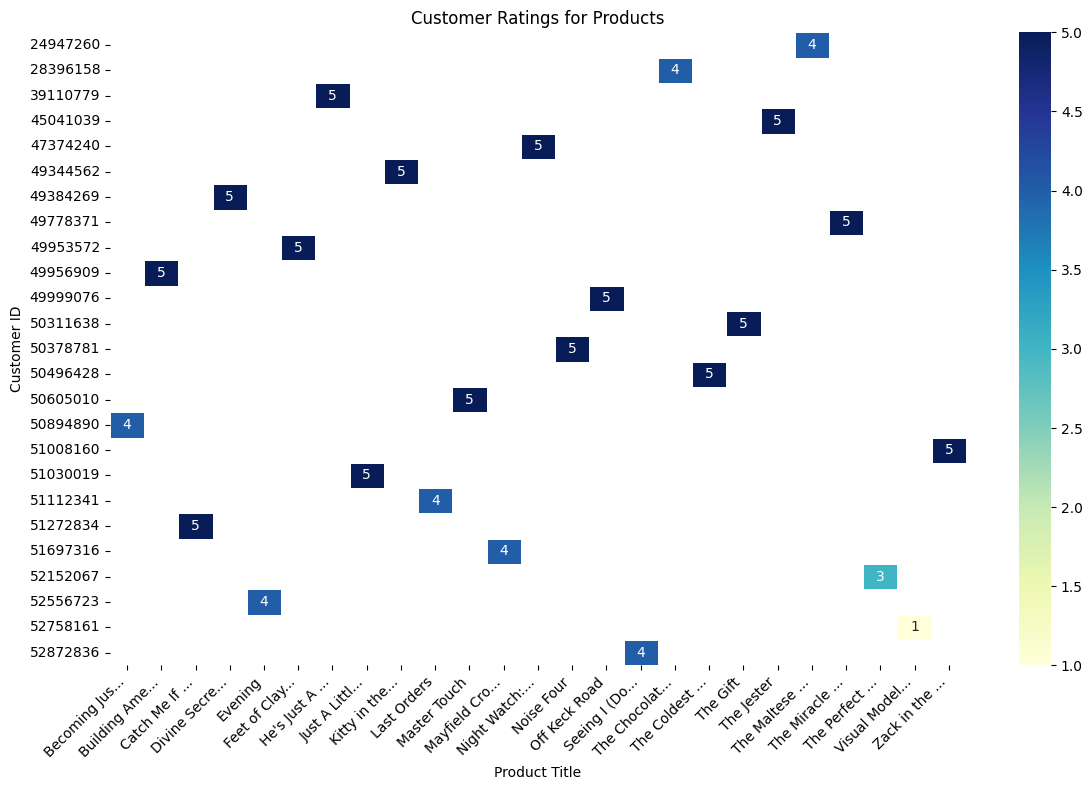

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'utility_matrix' is already defined from the previous code

def shorten_product_name(name):
    if len(name) > 15:
        return name[:12] + "..."
    return name

utility_matrix_shortened = utility_matrix.rename(columns=shorten_product_name)

plt.figure(figsize=(12, 8))
sns.heatmap(utility_matrix_shortened[utility_matrix_shortened > 0], annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5) # Use a different colormap
plt.title("Customer Ratings for Products")
plt.xlabel("Product Title")
plt.ylabel("Customer ID")
plt.xticks(rotation=45, ha="right") # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## Step 4: Choosing a Recommendation Strategy and model/algorithm

### Step 4.1: Choosing a Recommendation Strategy
Given the data, we can apply different recommendation approaches:

1.   **Collaborative Filtering**: Recommend products to customers based on other
customers with similar behavior (rating patterns).
2.   **Content-Based Filtering**: Recommend products based on product features like product_category and star_rating.

3.   **Hybrid Approach**: Combine both approaches to recommend products based on customer similarity and product similarity.



> We will be focusing on "Collaborative filtering" as Recommendastion strategy.







## Step 5: Implementing Collaborative Filtering using SVD (Matrix Factorization)

1.   Decompose the Matrix: SVD factorizes the matrix into user and item matrices.

2.   Reconstruct Ratings: This step estimates ratings for unrated items by multiplying the user and item matrices.



In [13]:
!pip install scikit-surprise # Install the necessary package

In [18]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_users_rating_df[['customer_id', 'product_id', 'star_rating']], reader)

# Split data
trainset, testset = train_test_split(data, test_size=0.3)

# Train model
model = SVD()
model.fit(trainset)

# Test model
predictions = model.test(testset)
accuracy.rmse(predictions)


RMSE: 0.9147


0.914708239972548

### Step 5.2: Choosing a alternative model/algorithm if any (via hyperparamter tuning)

Given the data and problem statement, we can apply different models:

1. SVD:
  - Decomposes rating matrix into latent factors representing user and item features.
  - Generally more accurate, especially for dense data.
  - Captures fine-grained preferences.
  - Computationally demanding for large data.
  - Less interpretable latent factors.
  - More sensitive to cold start problem.

2. CoClustering:

  - Clusters users and items based on rating patterns.
  - Efficient for large, sparse data.
  - Handles cold start problem well.
  - Interpretable clusters.
  - May not capture fine-grained preferences.



> We will use hyperparameter tuning to choose the best model.





In [33]:
from surprise.model_selection import RandomizedSearchCV
from surprise import SVD, Dataset, Reader, accuracy, KNNBasic, KNNWithMeans, KNNWithZScore, CoClustering
from surprise.model_selection import train_test_split

# # Reduce the size of the data
# reduced_df = filtered_users_rating_df.sample(frac=0.1, random_state=42)  # Use a smaller fraction if needed

# # Load data for Surprise using the reduced DataFrame
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(reduced_df[['customer_id', 'product_id', 'star_rating']], reader)

# # Split data
# trainset, testset = train_test_split(data, test_size=0.3)

# # ... (rest of your code for hyperparameter tuning and training)

algorithms = {
    "SVD": {
        "class": SVD,
        "param_grid": {"n_factors": [50, 100, 150], "n_epochs": [20, 30], "lr_all": [0.005, 0.01], "reg_all": [0.02, 0.1]}
    },
    "CoClustering": {
        "class": CoClustering,
        "param_grid": {"n_cltr_u": [2, 3, 4], "n_cltr_i": [2, 3, 4], "n_epochs": [20, 30]}
    },
}

# Perform RandomizedSearchCV for each algorithm
best_rmse = float('inf')
best_algorithm = None
best_params = None

for algorithm_name, algorithm_data in algorithms.items():
    algorithm_class = algorithm_data["class"]
    param_grid = algorithm_data["param_grid"]

    rs = RandomizedSearchCV(algorithm_class, param_grid, measures=['rmse'], cv=3, n_iter=10, random_state=42)
    rs.fit(data)

    print(f"Algorithm: {algorithm_name}, Best RMSE: {rs.best_score['rmse']}, Best Params: {rs.best_params['rmse']}")

    if rs.best_score['rmse'] < best_rmse:
        best_rmse = rs.best_score['rmse']
        best_algorithm = algorithm_class
        best_params = rs.best_params['rmse']

# Train the best model on the training set
best_model = best_algorithm(**best_params)
best_model.fit(trainset)

# Test the best model on the test set
predictions = best_model.test(testset)
accuracy.rmse(predictions)

Algorithm: SVD, Best RMSE: 0.9084827573737281, Best Params: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.02}
Algorithm: CoClustering, Best RMSE: 1.027218592994043, Best Params: {'n_cltr_u': 3, 'n_cltr_i': 4, 'n_epochs': 30}
RMSE: 0.9039


0.9038589841145902

In [34]:
best_algorithm

surprise.prediction_algorithms.matrix_factorization.SVD

## Step 6: Making Recommendations

In [28]:
# Get a list of all product IDs
all_product_ids = filtered_users_rating_df['product_id'].unique()

In [29]:
# Function to recommend top-N products
def recommend_products(customer_id, model=best_model, all_product_ids=all_product_ids, df=filtered_users_rating_df, n=10):
    # Predict ratings for each product not yet rated by this customer
    unrated_products = [pid for pid in all_product_ids if pid not in df[df['customer_id'] == customer_id]['product_id'].values]
    predictions = [model.predict(customer_id, pid) for pid in unrated_products]

    # Sort predictions by estimated rating
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]

    # Return the top N recommended product IDs
    recommended_product_ids = [pred.iid for pred in top_n]

    # Map product IDs to titles (assuming you have a DataFrame with product IDs and titles)
    recommended_products_with_titles = []
    for product_id in recommended_product_ids:
        product_title = df[df['product_id'] == product_id]['product_title'].iloc[0] if not df[df['product_id'] == product_id]['product_title'].empty else "Product Title Not Found"
        recommended_products_with_titles.append(product_title)

    return recommended_products_with_titles

In [40]:
# Select random 10 customers from testset to be used for testing the model prediction.
# Also provide then as drop down option to select and run the predict method. Don't trim the label for the dropdown

import random
import ipywidgets as widgets
from IPython.display import display

# Number of customers to randomly select from the testset
num_customers_to_select = 10

# Create a list of customer IDs from the testset
customer_ids_in_testset = [uid for (uid, iid, r) in testset]

# Randomly select customer IDs
random_customers = random.sample(customer_ids_in_testset, num_customers_to_select)

# Create a dropdown widget
customer_dropdown = widgets.Dropdown(
    options=random_customers,
    description='Select Customer ID:',
    disabled=False,
)

# Create a dropdown widget for top_n
top_n_dropdown = widgets.Dropdown(
    options=[3, 5, 7, 10],
    description='Select Top N:',
    disabled=False,
)


# Output widget for recommendations
output = widgets.Output()

# Create a submit button
submit_button = widgets.Button(description="Submit")

def on_submit_clicked(b):
    with output:
        output.clear_output()
        selected_customer_id = customer_dropdown.value
        selected_top_n = top_n_dropdown.value

        print(f"Selected Customer ID: {selected_customer_id}")
        print(f"Selected Top N: {selected_top_n}")
        print(f"Finding the recomendations..")

        recommendations = recommend_products(customer_id=selected_customer_id, n=selected_top_n)

        print(f"\nTop {selected_top_n} recommended products for user {selected_customer_id}:")
        for product in recommendations:
            print(product)

submit_button.on_click(on_submit_clicked)


# Create a horizontal box to place the dropdown widgets side by side
from ipywidgets import HBox


# Create a horizontal box for the dropdowns
hbox = HBox([customer_dropdown, top_n_dropdown, submit_button])

# Display the horizontal box and the button
display(hbox)
display(output)

Output()